### MountainCar-v0 with Gymnasium + Stable-Baselines3 (Step-by-Step)

In this notebook you'll:

- Inspect the MountainCar-v0 environment (state, actions, rewards)

- Run a random policy to build intuition

- Train a DQN agent with Stable-Baselines3

- Evaluate, record a short video, and plot learning curves

In [2]:
import gymnasium as gym
import numpy as np
import os 
import matplotlib.pyplot as plt

import stable_baselines3 as sb3
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

print("Gymnasium:", gym.__version__)
print("Stable-Baselines3:", sb3.__version__)

Gymnasium: 1.2.0
Stable-Baselines3: 2.7.0


### Meet MountainCar-v0

State (observation): [position, velocity] (shape: 2)

Actions: {0: push left, 1: no push, 2: push right}

Goal: Drive the underpowered car up the right hill (position ≥ 0.5).

Reward: −1 per step until the goal is reached (shorter episodes = better).

Episode ends: goal reached or after 200 steps.

In [3]:
env = gym.make("MountainCar-v0")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

obs, info = env.reset(seed=42)
print("Initial observation:", obs, " | info:", info)
print("Sample action:", env.action_space.sample())
env.close()

Observation space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space:  Discrete(3)
Initial observation: [-0.4452088  0.       ]  | info: {}
Sample action: 1


**Roll out one random episode**

This helps you see how the state evolves and why naive actions fail.
We'll track the car's position over time and plot it.

Episode length:  200  | Total reward: -200.0


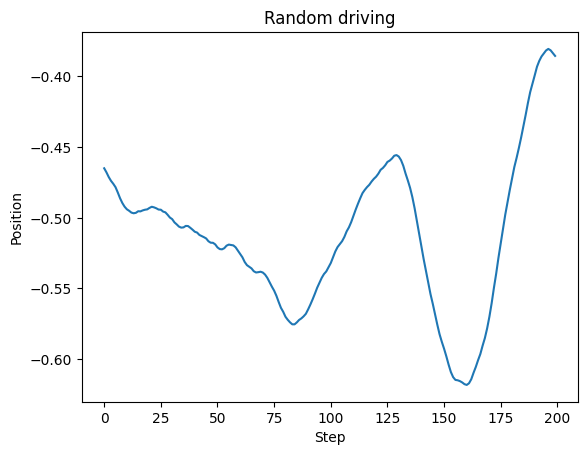

In [4]:
env = gym.make("MountainCar-v0")
positions = []
rewards = []
obs, info = env.reset(seed=123)

done = False
total_r = 0
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    positions.append(obs[0])
    rewards.append(reward)
    total_r += reward

env.close()

print("Episode length: ", len(rewards), " | Total reward:", total_r)

# Plot position over steps
plt.figure()
plt.plot(positions)
plt.title("Random driving")
plt.xlabel("Step")
plt.ylabel("Position")
plt.show()

In [5]:
from gymnasium.wrappers import RecordVideo

log_dir = "./mountaincar_logs"
video_dir = "./mountaincar_videos"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

# Monitored env for training stats
def make_env(seed=0):
    e = gym.make("MountainCar-v0", render_mode=None)
    e = Monitor(e, filename=os.path.join(log_dir, "monitor.csv"))
    return e

# A seperate env only for video to avoid slowing down training
def make_video_env(seed=123):
    e = gym.make("MountainCar-v0", render_mode="rgb_array")
    e = RecordVideo(e, video_folder=video_dir, episode_trigger=lambda ep : True)
    return e

print("Log dir:", log_dir)
print("Video dir:", video_dir)

Log dir: ./mountaincar_logs
Video dir: ./mountaincar_videos


In [6]:
env_video = gym.make("MountainCar-v0", render_mode="rgb_array")
env_video = RecordVideo(env_video, video_folder=video_dir, 
                        episode_trigger=lambda ep: True, name_prefix="test_run")

obs, info = env_video.reset(seed=2)
done = False
while not done:
    action = env_video.action_space.sample()
    obs, reward, terminated, truncated, info = env_video.step(action)
    done = terminated or truncated

env_video.close()
print("Sample video saved to: ", os.path.abspath(video_dir))

/Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/mountaincar_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Sample video saved to:  /Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/mountaincar_videos


A tiny callback to save the best model

We'll compute a simple moving mean of rewards using Monitor logs and save the best-performing checkpoint.

In [7]:
class SaveBest(BaseCallback):
    def __init__(self, check_freq, log_dir, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        os.makedirs(self.save_path, exist_ok=True)
        self.best_mean_reward = -np.inf

    def _on_step(self):
        if (self.n_calls % self.check_freq) == 0:
            try:
                # Load results and compute the mean reward
                x, y = ts2xy(load_results(self.log_dir), "timesteps")
                if len(y) > 0:
                    mean_reward = np.mean(y[-100])
                    if self.verbose:
                        print(f"Step {self.n_calls} | Last-100 mean reward: {mean_reward:.2f}")
                    if mean_reward > self.best_mean_reward:
                        self.best_mean_reward = mean_reward
                        path = os.path.join(self.save_path, "best_model")
                        self.model.save(path)
                        if self.verbose:
                            print(f"Saved new best model to {path}")
            except Exception as e:
                if self.verbose:
                    print("Error:", e)
        return True

In [11]:
env_train = make_env()
model = DQN(
    policy="MlpPolicy",
    env=env_train,
    learning_rate=4e-3,
    buffer_size=10_000,
    learning_starts=1_000,
    batch_size=128,
    gamma=0.98,
    train_freq=16,
    gradient_steps = 8,
    target_update_interval=600,
    exploration_fraction=0.2,   # explore for ~20% of training
    exploration_final_eps=0.07,
    verbose=1,
    tensorboard_log=os.path.join(log_dir, "tb")
)

callback = SaveBest(check_freq=5_000, log_dir=log_dir, verbose=1)
timesteps = 600_000  # try 200_000+ for better results
model.learn(total_timesteps=timesteps, callback=callback)
model.save(os.path.join(log_dir, "final_model"))
env_train.close()
print("Training done.")


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./mountaincar_logs/tb/DQN_8
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 33871    |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8387     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 4.25e-05 |
|    n_updates        | 296      |
----------------------------------

### Evaluate the policy

We measure average return over several episodes. MountainCar returns are negative; less negative is better. Success corresponds to quickly reaching the goal (position ≥ 0.5).

In [12]:
eval_env = gym.make("MountainCar-v0")
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, render=False, deterministic=True)
eval_env.close()
print(f'Mean reward over 10 episodes: {mean_reward:.2f} ± {std_reward:.2f}')

Mean reward over 10 episodes: -122.50 ± 27.77


/Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/.venv/lib/python3.13/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


### Watch a rollout (video)

We'll load the best checkpoint if available, otherwise the final model, and record one episode.

In [ ]:
# Try to load best checkpoint
best_path = os.path.join(log_dir, "best_model", "best_model.zip")
if os.path.exists(best_path):
    print("Loading best checkpoint:", best_path)
    model = DQN.load(best_path)
else:
    print("Best checkpoint not found - using final model")
    model =  DQN.load(os.path.join(log_dir, "final_model.zip"))

vid_env = make_video_env()
obs, info = vid_env.reset(seed=3)
done = False
ep_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = vid_env.step(action)
    done = terminated or truncated
    ep_reward += reward
vid_env.close()
print("Recorded one episode. Reward:", ep_reward)
print("Check the video folder:", os.path.abspath("mountaincar_videos"))


Loading best checkpoint: ./mountaincar_logs/best_model/best_model.zip
Recorded one episode. Reward: -124.0
Check the video folder: /Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/mountaincar_videos


### Plot the learning curve

We'll parse the Monitor log and plot episode rewards over training timesteps.

,r,l,t,timesteps,r_smooth
0,-200.0,200.0,0.011656,200.0,-200.0
1,-200.0,200.0,0.016435,400.0,-200.0
2,-200.0,200.0,0.021155,600.0,-200.0
3,-200.0,200.0,0.027623,800.0,-200.0
4,-200.0,200.0,0.033418,1000.0,-200.0


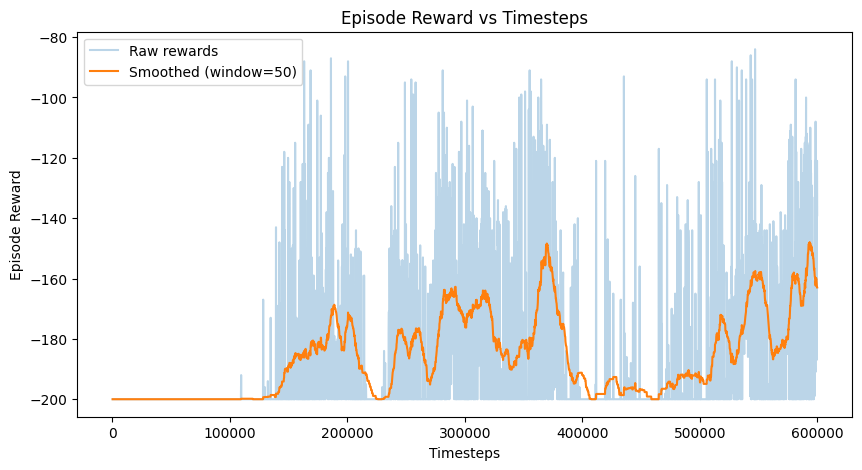

In [ ]:
import pandas as pd
from glob import glob

monitor_files = glob(os.path.join(log_dir, "*monitor.csv")) + glob(os.path.join(log_dir, "monitor.csv"))
if not monitor_files:
    print("No monitor file found.")
else: 
    # Load Monitor CSV, skip header and comments
    df = pd.read_csv(
        monitor_files[0],
        skiprows=2,
        comment="#",
        names=["r", "l", "t"] # r: reward, l: length, t:times
    )
    df = df.astype(float)
    df["timesteps"] = df["l"].cumsum()

    # Moving averages over rewards
    window = 50
    df["r_smooth"] = df["r"].rolling(window, min_periods=1).mean()

    display(df.head())

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df["timesteps"], df["r"], alpha=0.3, label="Raw rewards")
    plt.plot(df["timesteps"], df["r_smooth"], label=f"Smoothed (window={window})")
    plt.title("Episode Reward vs Timesteps")
    plt.xlabel("Timesteps")
    plt.ylabel("Episode Reward")
    plt.legend()
    plt.show()
    

## Greedy Policy
After training, we take the **best action** from each state (highest Q-value).  
We can display it as arrows on the grid.
